# Séance 1 - Bonus : Première régularisation d'un réseau de neurones

Pour poursuivre le travail du TP, on se propose d'explorer une première manière de régulariser un réseau de neurones. Nous avons vu que nous pouvions atteindre de bonne performances, mais que cela entraînait fréquemment un sur-apprentissage. 
Une des premières manières de régulariser que l'on apprend en Machine Learning est de pénaliser une régression linéaire : c'est la régression Ridge. Le principe est de modifier la fonction de perte pour contraindre les poids appris à être *petit*. Il est possible de le faire couche par couche dans un réseau de neurones. Essayons !

Commençons par importer et traiter les données.

In [1]:
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style='whitegrid')

import tensorflow as tf
from tensorflow import keras

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

(X_train_full, y_train_full), (X_test, y_test) = (keras.datasets.mnist.load_data())
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, train_size=0.8)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train.astype(np.float32).reshape(-1, 28 * 28)).reshape(-1, 28, 28)
X_valid = scaler.transform(X_valid.astype(np.float32).reshape(-1, 28 * 28)).reshape(-1, 28, 28)
X_test = scaler.transform(X_test.astype(np.float32).reshape(-1, 28 * 28)).reshape(-1, 28, 28)

## Pénalisation $L_2$

La pénalisation à laquelle on s'intéresse ici est la pénalisation $L_2$. Si l'on considère un problème d'optimisation d'une fonction de perte $\mathcal{L}$

$$w^* = \arg\min_{w\in\mathbb{R}^d} \mathcal{L}(w)$$

Alors sa version pénalisée est la suivante avec $\lambda > 0$ :

$$w^* = \arg\min_{w\in\mathbb{R}^d} \mathcal{L}(w) + \lambda\|w\|^2$$

Ce n'est plus exactement le même objectif puisqu'on force ici le vecteur solution $w^*$ a prendre de plus petite valeurs. Nous pouvons faire cela couche par couche.

**Consigne** : Définir un modèle en ajoutant une pénalisation [$L_2$](https://keras.io/api/layers/regularizers/#l2-class) aux couches [`Dense`](https://keras.io/api/layers/core_layers/dense/).

In [3]:
lambda_l2 = 1e-3

model = keras.models.Sequential([
    keras.layers.Input(shape=(28, 28)),
    keras.layers.Flatten(),
    keras.layers.Dense(528, activation="relu", kernel_initializer="he_normal", kernel_regularizer=keras.regularizers.l2(l2=lambda_l2)),
    keras.layers.Dense(256, activation="relu", kernel_initializer="he_normal", kernel_regularizer=keras.regularizers.l2(l2=lambda_l2)),
    keras.layers.Dense(256, activation="relu", kernel_initializer="he_normal", kernel_regularizer=keras.regularizers.l2(l2=lambda_l2)),
    keras.layers.Dense(256, activation="relu", kernel_initializer="he_normal", kernel_regularizer=keras.regularizers.l2(l2=lambda_l2)),
    keras.layers.Dense(10, activation="softmax")
])

2024-09-15 12:06:57.648687: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2024-09-15 12:06:57.648708: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-09-15 12:06:57.648714: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-09-15 12:06:57.648733: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-09-15 12:06:57.648747: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


**Consigne** : Lancer sur quelques époques le modèle pour valider qu'il fonctionne correctement.

In [4]:
epochs = 5
batch_size = 256

model.compile(loss="sparse_categorical_crossentropy", optimizer=keras.optimizers.SGD(learning_rate=1e-3), metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_valid, y_valid))

Epoch 1/5


2024-09-15 12:06:59.193995: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.1874 - loss: 4.9780 - val_accuracy: 0.4732 - val_loss: 4.3771
Epoch 2/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5296 - loss: 4.2422 - val_accuracy: 0.6562 - val_loss: 3.9245
Epoch 3/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6862 - loss: 3.8250 - val_accuracy: 0.7405 - val_loss: 3.6305
Epoch 4/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7537 - loss: 3.5626 - val_accuracy: 0.7853 - val_loss: 3.4424
Epoch 5/5
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7964 - loss: 3.3810 - val_accuracy: 0.8138 - val_loss: 3.3207


De la même manière que l'on souhaitais observer l'impact du learning rate sur l'entraînement, on souhaite mesurer l'apport de la régularisation au modèle. 

## Mesure de l'impact de la régularisation

**Consigne** : Définir une fonction `get_model` qui prend en paramètre :
* *lambda_l2* : float correspondant à la magnitude de la pénalisation $L_2$
* *learning_rate* : float par défaut à $0.001$ correspond au learning rate de l'optimizer

La fonction renvoie le modèle compilé.

In [5]:
def get_model(lambda_l2=1e-3, learning_rate=1e-3):
    model = keras.models.Sequential([
        keras.layers.Input(shape=(28, 28)),
        keras.layers.Flatten(),
        keras.layers.Dense(256, activation="relu", kernel_regularizer=keras.regularizers.l2(l2=lambda_l2)),
        keras.layers.Dense(128, activation="relu", kernel_regularizer=keras.regularizers.l2(l2=lambda_l2)),
        keras.layers.Dense(10, activation="softmax")
    ])

    model.compile(loss="sparse_categorical_crossentropy", optimizer=keras.optimizers.SGD(learning_rate=learning_rate), metrics=["accuracy"])
    return model

**Consigne** : En s'inspirant du travail réalisé pour le learning rate, comparer différente valeur de régularisation. Commenter.

Lambda= 0.000000 - époques: 100
Lambda= 0.100000 - époques: 100
Lambda= 0.010000 - époques: 100
Lambda= 0.001000 - époques: 100


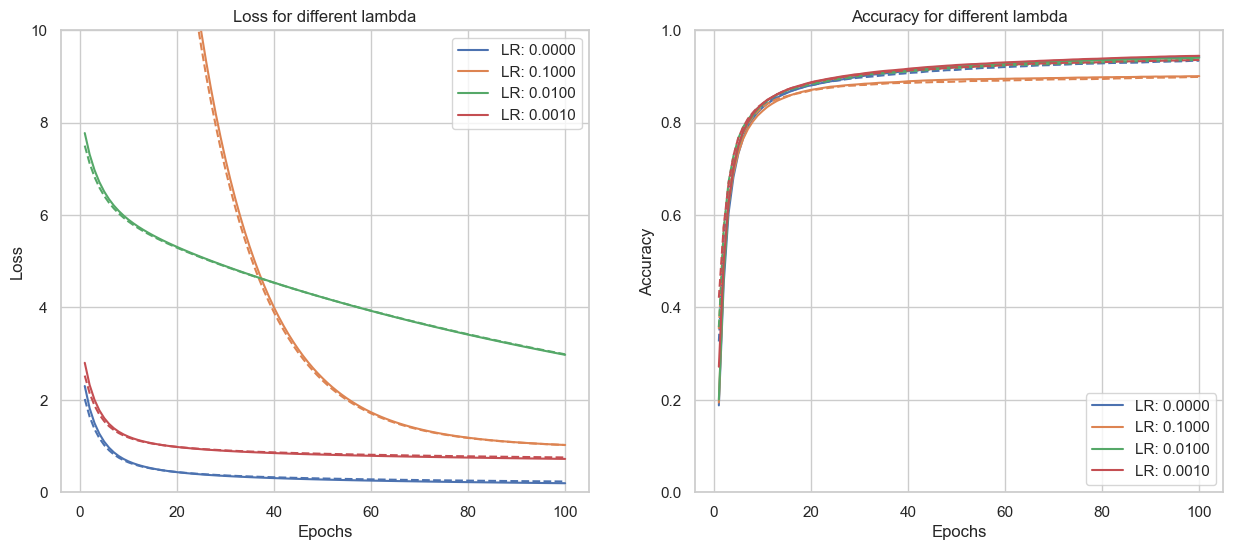

In [7]:
def show_results(results, figsize=(15, 6)):
    n_epochs = results[0]["history"].shape[0]
    epochs = range(1, n_epochs+1)

    figure, (axis_1, axis_2) = plt.subplots(1, 2, figsize=figsize)

    for index, result in enumerate(results):
        color = sns.color_palette()[index]
        history = result["history"]
        plt.subplot(1, 2, 1)
        axis_1.plot(epochs, history["loss"], label="LR: %0.4f" % result["lambda"], color=color)
        axis_1.plot(epochs, history["val_loss"], '--', color=color)

        axis_2.plot(epochs, history["accuracy"], label="LR: %0.4f" % result["lambda"], color=color)
        axis_2.plot(epochs, history["val_accuracy"], '--', color=color)

    axis_1.set_ylim(bottom=0, top=10)
    axis_2.set_ylim(0, 1)
    for axis in [axis_1, axis_2]:
        axis.set_xlabel("Epochs")
        axis.legend()

    axis_1.set_ylabel("Loss")
    axis_1.set_title("Loss for different lambda")

    axis_2.set_ylabel("Accuracy")
    axis_2.set_title("Accuracy for different lambda")

    plt.show()



n_epochs = 100
batch_size = 256
learning_rate = 1e-3
lambdas_l2 = [0, 1e-1, 1e-2, 1e-3]

results = []
for lambda_l2 in lambdas_l2:
  print("Lambda= %f - époques: %d" % (lambda_l2, n_epochs))
  model = get_model(lambda_l2=lambda_l2, learning_rate=learning_rate)
  history = model.fit(X_train, y_train, epochs=n_epochs, batch_size=batch_size, validation_data=(X_valid, y_valid), verbose=0)
  result = {"lambda": lambda_l2, "history": pd.DataFrame(history.history)}
  results.append(result)

show_results(results)

Les fonctions de loss on des valeurs très différentes en fonction de la force de la pénalisation. Notons tout de même le cas particulier où $\lambda = 0.1$ qui converge rapidement vers une *bonne* solution mais peine à continuer de progresser. En revanche la régularisation avec $\lambda = 0.01$ permet d'obtenir une bonne accuracy et la fonction de perte continue de descendre à un bon rythme.